In [15]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\isancmen\appdata\local\temp\pip-req-build-6vswpa0f
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.05f7512b8cfdad566d72ddde2a5abafbfdcd4ee1e_-cp37-none-any.whl size=112525 sha256=294a8f1758c33dd2b95094552b302337197f8ecbb62b5bf2ee189764714c7cc7
  Stored in directory: C:\Users\isancmen\AppData\Local\Temp\pip-ephem-wheel-cache-smsx1038\wheels\eb\1b\35\fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\isancmen\AppData\Local\Temp\pip-req-build-6vswpa0f'


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import h5py
import logging
from os import path
from pandas import HDFStore
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers


%matplotlib inline

In [2]:
logdir = pathlib.Path("./fmri")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
logdir

WindowsPath('fmri/tensorboard_logs')

In [4]:
#Load data from hdf5 file
seed=38

# origin h5 file location, load and shuffle timeseries
#h5_file = '/results/00-EXTRACCION-CEREBELO/elekin_fmri_ts_pandas.hdf5'

#windows
h5_file = "Z:/elekin/02-RESULTADOS/00-EXTRACCION-CEREBELO/elekin_fmri_ts_pandas.hdf5"

tr_key = 'cbl/dataset'#transformed dataset (id,time series matrix 158x28, label)
dataset = pd.read_hdf(h5_file, tr_key)

num_samples = dataset.shape[0]
features = np.stack(dataset['features'].values)
labels = dataset['label'].values.astype('int8')

features.shape, labels.shape

((94, 158, 28), (94,))

In [5]:
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.2)

In [6]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=101, min_delta=0.0001),
        tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, batch_size=None, use_multiprocessing=True, 
                        validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                        verbose=0)
    return history

## Recurrent Neural Network LSTM

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [7]:
STEPS_PER_EPOCH = 1
FEATURES = 158
CHANNELS = 28

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [8]:
size_histories = {}

In [9]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['lstm/tiny'] = compile_and_fit(lstm, "lstm/tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                5088      
_________________________________________________________________
dense (Dense)                (None, 16)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


W0821 01:10:45.830513  6700 deprecation.py:323] From C:\Users\isancmen\AppData\Local\Continuum\anaconda3\envs\pyrestfmri\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0821 01:11:12.153394  6700 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (11.903322). Check your callbacks.



Epoch: 0, accuracy:0.5733,  loss:0.6934,  val_accuracy:0.4211,  val_loss:0.6942,  
....................................................................................................
Epoch: 100, accuracy:0.9067,  loss:0.2736,  val_accuracy:0.6316,  val_loss:0.8734,  
.................................................................................................

In [20]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
small = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.LSTM(256, activation=tf.nn.tanh),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['lstm/small'] = compile_and_fit(small, "lstm/small", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 158, 256)          291840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 821,409
Trainable params: 821,409
Non-trainable params: 0
_________________________________________________________________


W0821 01:44:12.209946  6700 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (30.185225). Check your callbacks.



Epoch: 0, accuracy:0.5467,  loss:0.6934,  val_accuracy:0.4211,  val_loss:0.6993,  
....................................................................................................
Epoch: 100, accuracy:0.9867,  loss:0.0518,  val_accuracy:0.5789,  val_loss:1.6880,  
..................................................

(0.0, 2.15)

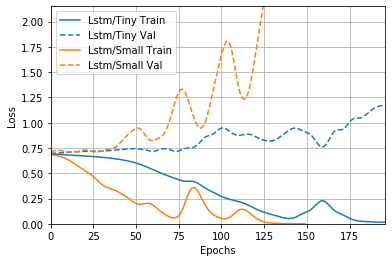

In [22]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 2.15])

(0.3, 1.02)

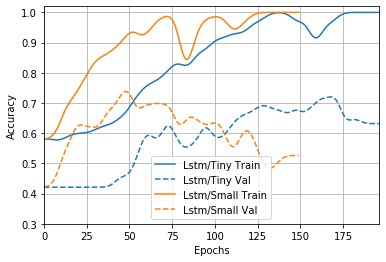

In [21]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0.3, 1.02])

## Bidirectional

In [23]:
shutil.rmtree(logdir/'lstm/regularizers/tiny', ignore_errors=True)
shutil.copytree(logdir/'lstm/tiny', logdir/'lstm/regularizers/tiny')
regularizer_histories = {}
regularizer_histories['tiny'] = size_histories['lstm/tiny']

In [24]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.relu),input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation=tf.nn.relu)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
regularizer_histories['bi-tiny'] = compile_and_fit(lstm, "lstm/regularizers/bi-tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 158, 512)          583680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,166,945
Trainable params: 2,166,945
Non-trainable params: 0
_________________________________________________________________


W0821 02:01:02.183691  6700 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (50.462348). Check your callbacks.



Epoch: 0, accuracy:0.5733,  loss:0.6934,  val_accuracy:0.4211,  val_loss:0.6951,  
....................................................................................................
Epoch: 100, accuracy:0.5733,  loss:nan,  val_accuracy:0.4211,  val_loss:nan,  
......................

### Regularization

In [25]:
# Drop out
dr=0.4
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.LSTM(256, activation=tf.nn.tanh),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)],)
regularizer_histories['drop-tiny'] = compile_and_fit(lstm, "lstm/regularizers/drp-tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 158, 256)          291840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

W0821 02:42:19.825484  6700 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (22.841031). Check your callbacks.



Epoch: 0, accuracy:0.5200,  loss:0.6925,  val_accuracy:0.5263,  val_loss:0.6940,  
....................................................................................................
Epoch: 100, accuracy:0.9200,  loss:0.2221,  val_accuracy:0.6842,  val_loss:1.4476,  
........................................................................

In [17]:
# Drop out
dr=0.25
lr=8e-2
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, activation=tf.nn.tanh, kernel_regularizer=regularizers.l2(lr), input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(lr)),
    tf.keras.layers.Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(lr)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l2(lr))],)
regularizer_histories['kernel'] = compile_and_fit(lstm, "lstm/regularizers/kernel-reg", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                5088      
_________________________________________________________________
dense (Dense)                (None, 16)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


W0821 01:37:07.653863  6700 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (10.966557). Check your callbacks.



Epoch: 0, accuracy:0.5733,  loss:6.7009,  val_accuracy:0.4211,  val_loss:6.5566,  
....................................................................................................
Epoch: 100, accuracy:0.5733,  loss:1.1072,  val_accuracy:0.4211,  val_loss:1.1381,  
..

(0.0, 2.15)

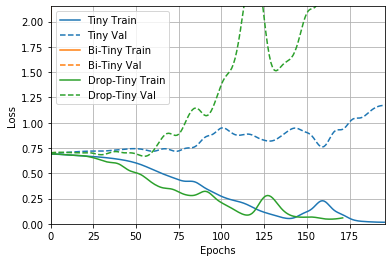

In [26]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 2.15])

(0.3, 1.02)

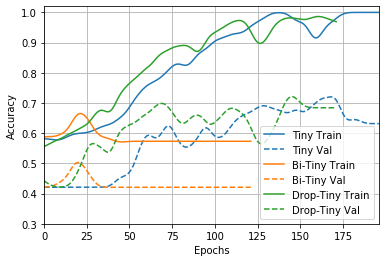

In [27]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(regularizer_histories)
plt.ylim([0.3, 1.02])